In [30]:
from datasetcontroller.datacontroller import DataController
import os
import tensorflow as tf
from nnmodules.unet import Unet_v2
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin

from rasterio.warp import calculate_default_transform, reproject, Resampling

* 데이터셋 정리

In [2]:
# set dataset path
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# get controller
datacontroller = DataController(data_path = data_path)

# control matrix, smoke, cmaq 
control_matrix, smoke_arr, target_arr = datacontroller.get_yearly_dataset()
print(control_matrix.shape, smoke_arr.shape, target_arr.shape)

# sum by region()    region별 총량으로 정리된 데이터셋
r_based_smoke = datacontroller.get_region_based_reshaped_smoke(smoke_arr)

# 그리드베이스 웨이트로 다시 펼친 데이터셋
base_smoke = smoke_arr[0]
reshaped_smoke_dataset = datacontroller.region_based_smoke_to_grid_base(r_smoke_dataset=r_based_smoke,grid_weights=base_smoke)

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:45: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


(120, 119) (120, 82, 67, 6) (120, 82, 67, 1)


* 정리된 데이터 좌표계 일치여부 체크

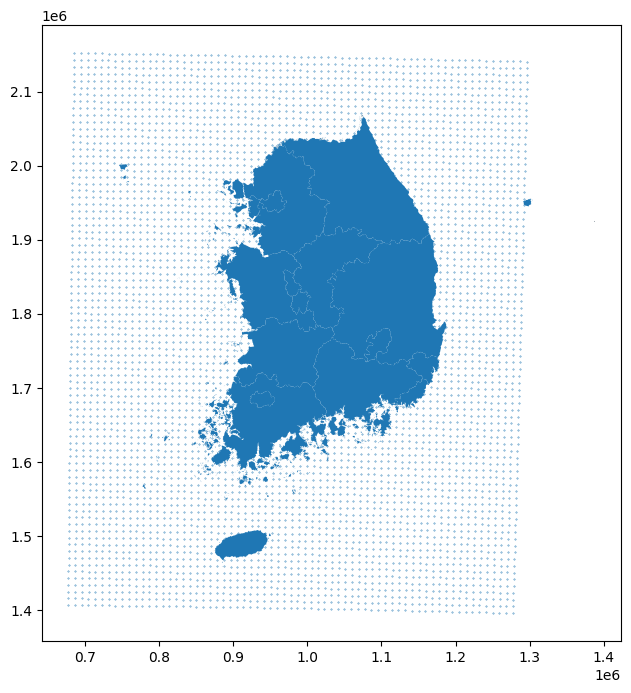

In [3]:
datacontroller.check_grid_ctp_shp_map()

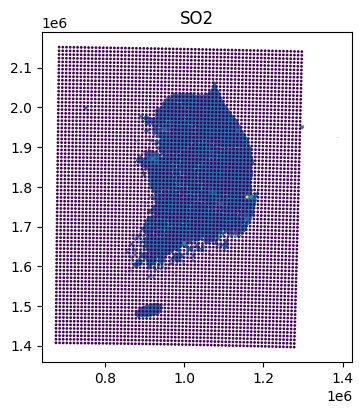

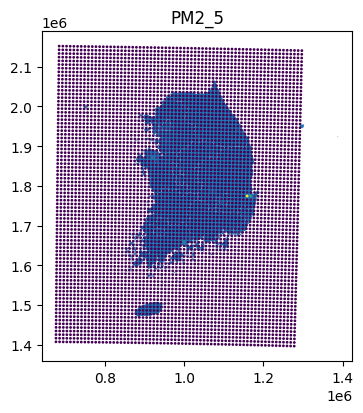

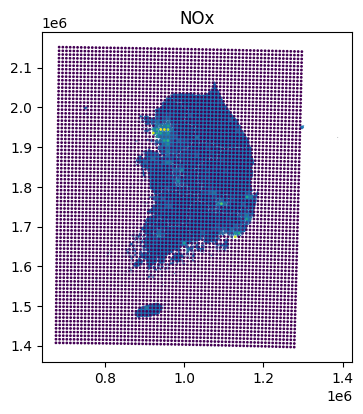

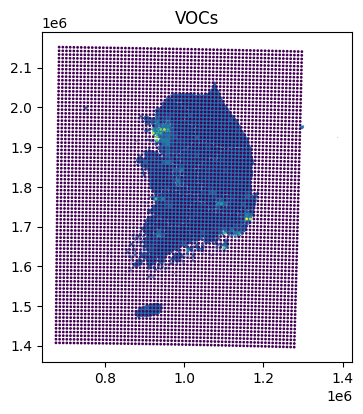

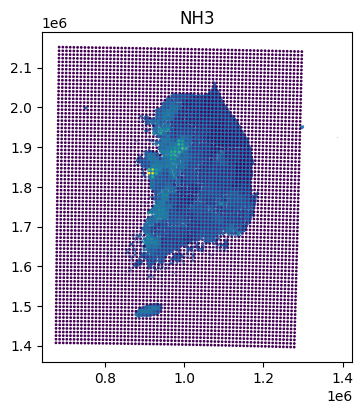

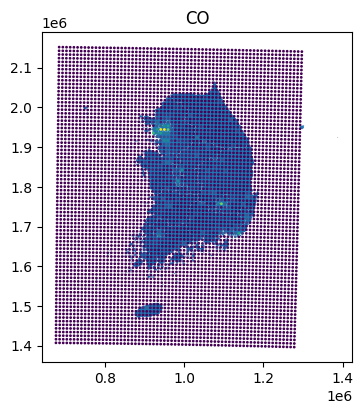

In [4]:
datacontroller.check_grid_based_smoke(reshaped_smoke_dataset[0])

* 모델 학습

In [12]:
train_set_len = 100
shuffle_buffer_size = train_set_len
batch_size = 10
steps = 3000
init_lr = 0.001

In [13]:
# 학습용 데이터셋 생성
train_input = reshaped_smoke_dataset[:train_set_len]
test_input = reshaped_smoke_dataset[train_set_len:]

train_output = target_arr[:train_set_len]
test_output = target_arr[train_set_len:]

test_input_reshaped = np.concatenate(test_input).reshape(-1,82,67,6)
train_input_reshaped = np.concatenate(train_input).reshape(-1,82,67,6)

train_input_ds = tf.data.Dataset.from_tensor_slices(train_input_reshaped)
train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

test_input_ds = tf.data.Dataset.from_tensor_slices(test_input_reshaped)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)

train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(batch_size).shuffle(shuffle_buffer_size)
test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(batch_size).shuffle(shuffle_buffer_size)

In [14]:
net = Unet_v2()
net.compile()
optimizer = tf.keras.optimizers.Adam(init_lr)

@tf.function
def train_step(input_image, target,optimizer):
    with tf.GradientTape() as tape:
        output = net(input_image, training=True)
        l1_loss = net.lose_mse(target, output)
    gradients = tape.gradient(l1_loss,
                                            net.trainable_variables)

    optimizer.apply_gradients(zip(gradients,
                                            net.trainable_variables))


In [15]:
start = time.time()

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():
  
  if (step) % 100 == 0:
    if step != 0:
      print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

    start = time.time()
    print(f"Step: {step}")

  train_step(input_arr, target,optimizer)

  if step % 1000 == 0:
    if step != 0:
      init_lr = init_lr*0.1
      optimizer = tf.keras.optimizers.Adam(init_lr)
      @tf.function
      def train_step(input_image, target,optimizer):
          with tf.GradientTape() as tape:
              output = net(input_image, training=True)
              l1_loss = net.lose_mse(target, output)
          gradients = tape.gradient(l1_loss,
                                                  net.trainable_variables)

          optimizer.apply_gradients(zip(gradients,
                                                  net.trainable_variables))

  # Training step
  if (step+1) % 10 == 0:
    print('.', end='', flush=True)


  # # Save (checkpoint) the model every 5k steps
  # if (step + 1) % 1000 == 0:
  #   checkpoint.save(file_prefix=checkpoint_prefix)

2023-05-24 06:06:59.357042: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


Step: 0
..........Time taken for 100 steps: 19.80 sec

Step: 100
..........Time taken for 100 steps: 11.98 sec

Step: 200
..........Time taken for 100 steps: 11.98 sec

Step: 300
..........Time taken for 100 steps: 11.99 sec

Step: 400
..........Time taken for 100 steps: 11.97 sec

Step: 500
..........Time taken for 100 steps: 11.98 sec

Step: 600
..........Time taken for 100 steps: 11.98 sec

Step: 700
..........Time taken for 100 steps: 11.98 sec

Step: 800
..........Time taken for 100 steps: 11.98 sec

Step: 900
..........Time taken for 100 steps: 11.98 sec

Step: 1000
..........Time taken for 100 steps: 19.94 sec

Step: 1100
..........Time taken for 100 steps: 11.96 sec

Step: 1200
..........Time taken for 100 steps: 11.96 sec

Step: 1300
..........Time taken for 100 steps: 11.96 sec

Step: 1400
..........Time taken for 100 steps: 11.96 sec

Step: 1500
..........Time taken for 100 steps: 11.96 sec

Step: 1600
..........Time taken for 100 steps: 11.97 sec

Step: 1700
..........Time 

4/4 [==============================] - 1s 89ms/step


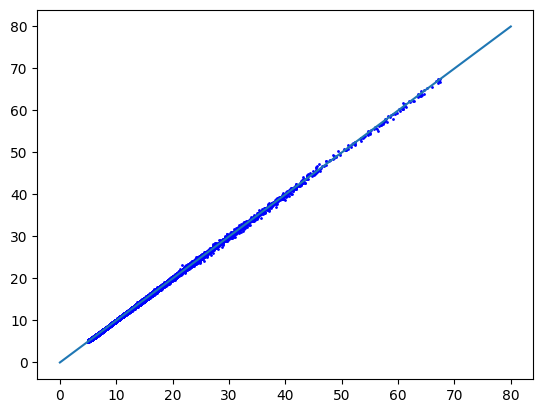

In [16]:
pred_train = net.predict(train_input_reshaped)
plt.plot(pred_train.reshape(-1), train_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

1/1 [==============================] - 0s 29ms/step


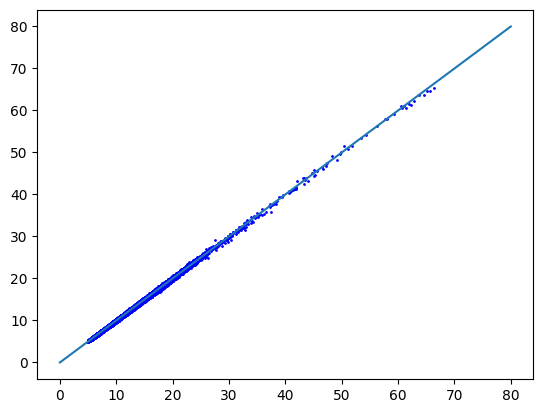

In [17]:
pred_test = net.predict(test_input_reshaped)
plt.plot(pred_test.reshape(-1), test_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

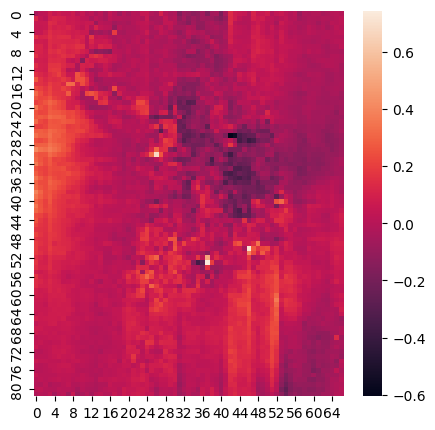

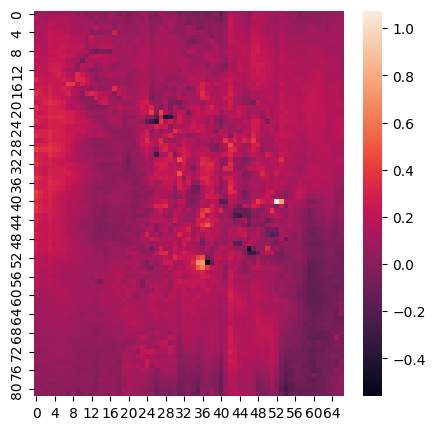

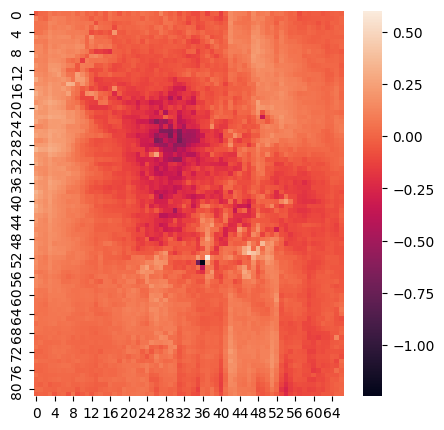

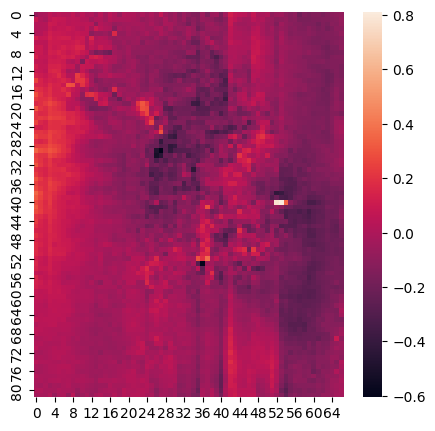

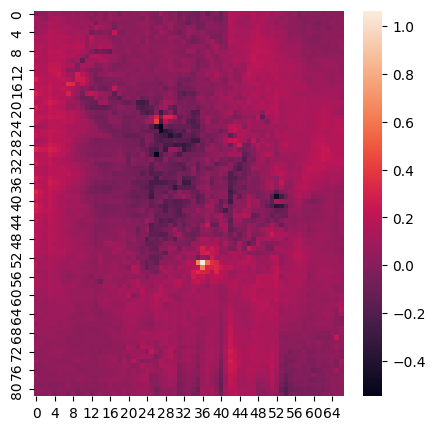

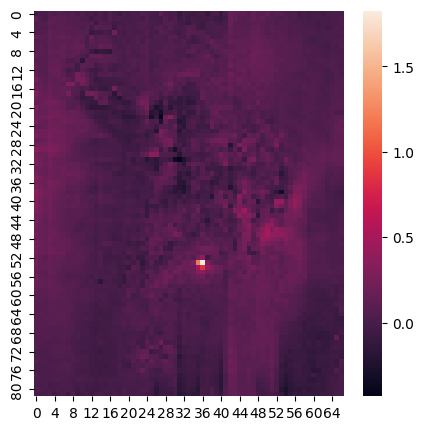

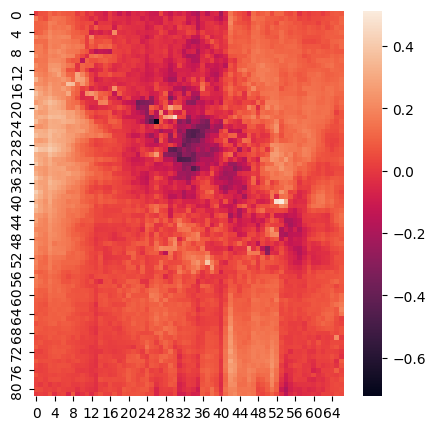

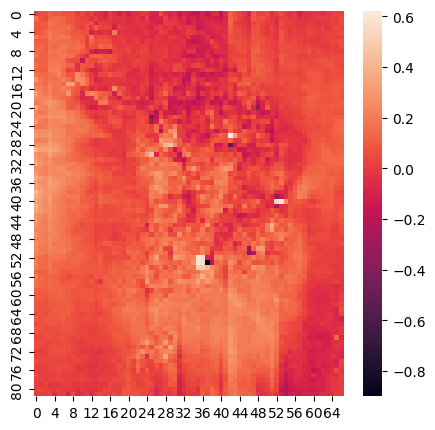

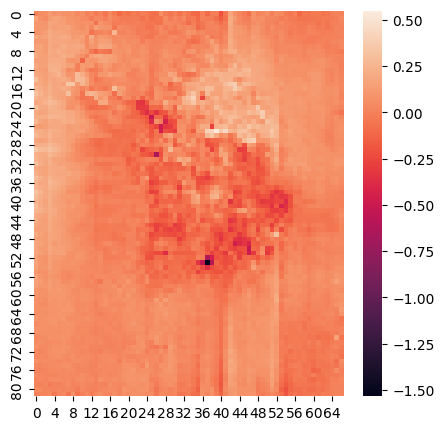

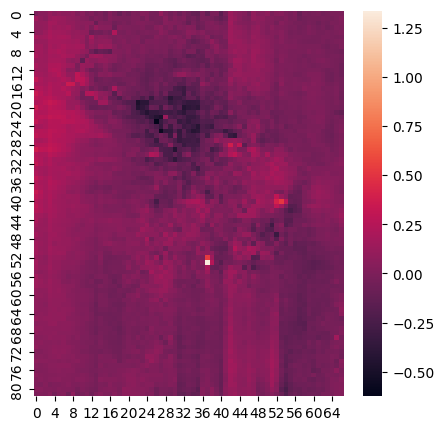

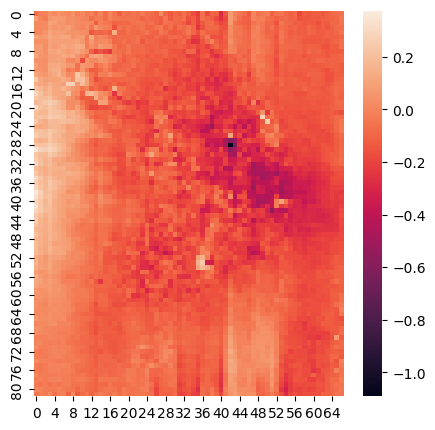

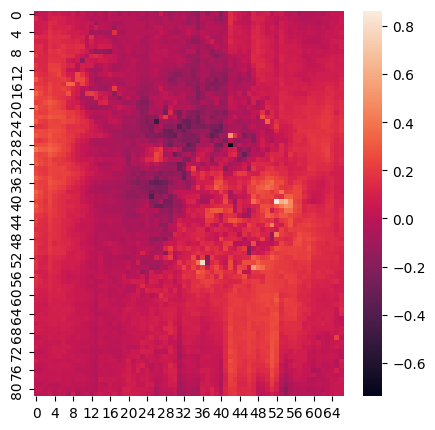

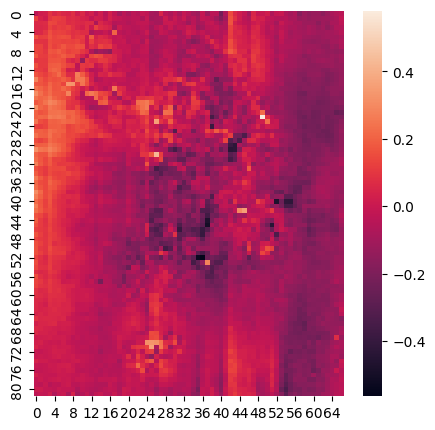

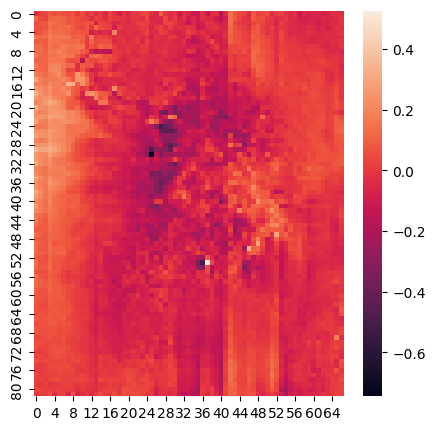

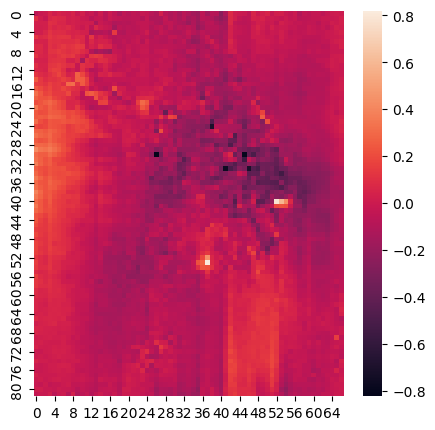

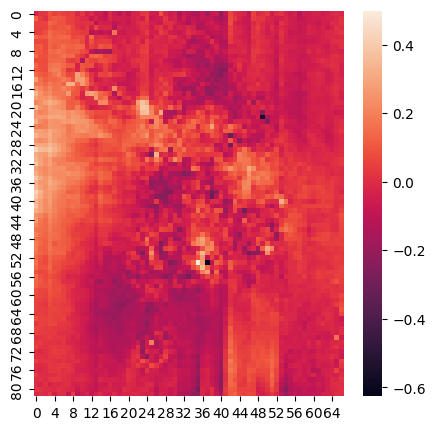

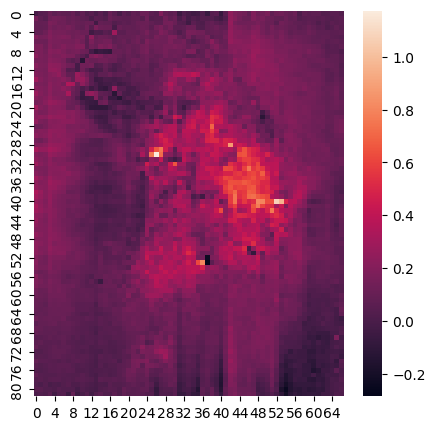

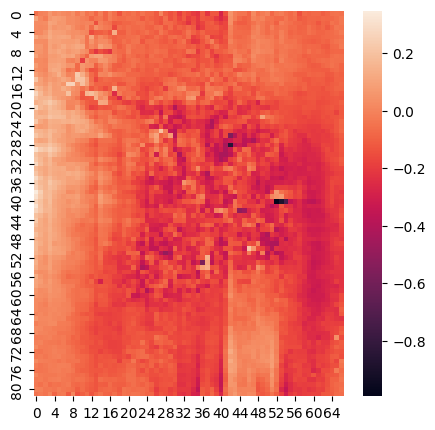

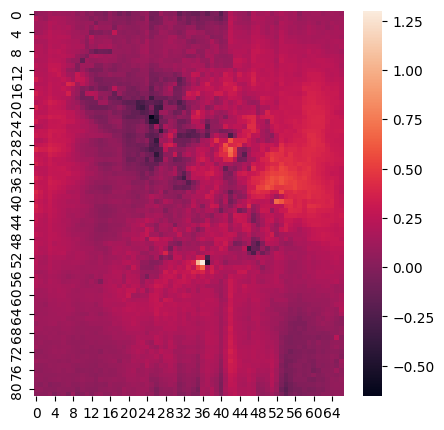

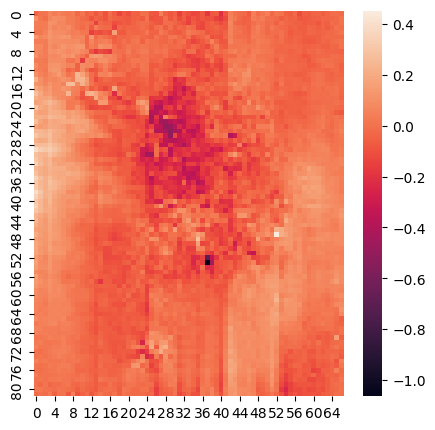

In [18]:
for i in range(len(pred_test)):
    plt.figure(figsize = [5,5])
    sns.heatmap(pred_test[i][:,:,0][::-1] - test_output[i][:,:,0][::-1])